# HELIOS Seq Analysis of Hek cells
## What has been done so far...
Several DataProcessing steps were done till here with other software on the computational cluster
* fastq were trimmed and demultiplexed with cutadapt
* quality checked and further trimmed with trimmomatic
* reads were aligned with hisat2 to reference genome and reference spikeRNA, done for merged reads and not merged/paired reads separately
* count tables produced with featureCounts
* a custom python script extracts output from hisat2 for the spike RNAs and puts them in a table for further processing
* in 01_Analysis data was
  * annotated
  * filtered
  * normalized
  * spike content was compared
* in 02_Analysis calculation were made:
  * enrichmentfactors
  * logfoldchanges
  * statistical tests



In [1]:
# import required modules
import os
import pandas as pd
import numpy as np
import anndata as ad
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from confidence_ellypse import confidence_ellipse
from matplotlib_venn import venn3, venn3_circles, venn2

colors = sns.color_palette("tab10")
colors[8] = "gold"

from sklearn.preprocessing import StandardScaler

#pd.set_option('display.max_columns', None)

In [2]:
adata = ad.read_h5ad("data/anndata.h5ad")
adata

AnnData object with n_obs × n_vars = 24 × 5588
    obs: 'encoding', 'pos_neg', 'treatment', 'gene_counts', 'biotinRna', 'biotin_scalingF'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length', 'Ensemble_ID', 'ensembl_gene_id', 'external_gene_name', 'description', 'gene_biotype', 'entrezgene_id', 'start_position', 'end_position', 'chromosome_name', 'total_values', 'highest_sample', 'NADcap_Control', 'NADcap_FK', 'NADcap_NRH', 'NADcap_Rot', 'sums'
    uns: 'L2FC_spikes', 'enrichmentfactors_spikes', 'normalized_spike_counts', 'original_spike_table', 'spike_correlation', 'spike_counts'
    varm: 'L2FC', 'L2FC_mean_statTests', 'enrichmentfactors'
    layers: 'biotin_scaled'

In [3]:
sig_genes_previous_analysis = {}
for file in os.walk("data/tay_datasets"):
    data_sets = file[2]
for dataset in data_sets:
    df = pd.read_csv("data/tay_datasets/" + dataset)["ensembl_gene_id_version"]
    sig_genes_previous_analysis[dataset] = set(df)
sig_genes_previous_analysis.keys()

dict_keys(['vol_data_nrh_sig.csv', 'vol_data_old_sig.csv', 'vol_data_fk_sig.csv', 'vol_data_con_sig.csv', 'vol_data_rot_sig.csv'])

In [4]:
treatments = ["Control", "NRH", "FK", "Rot"]
sig_genes_new_analysis = {}
for treat in treatments:
    sig_genes_new_analysis[treat] = set(adata.var[adata.var["NADcap_" + treat] == True].index)


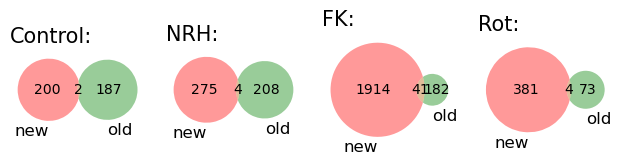

In [5]:
pairs = {
    "NRH" : "vol_data_nrh_sig.csv",
    "Control" : "vol_data_con_sig.csv",
    "FK" : "vol_data_fk_sig.csv",
    "Rot" : "vol_data_rot_sig.csv",
}

union_intersect = set([])

NADcapped_genes ={}
fig, axs = plt.subplots(1,4)
axs = axs.ravel()

for ax, treat in zip(axs, treatments):  
    
    set1 = sig_genes_new_analysis[treat]
    name_set2 = pairs[treat]
    set2 = sig_genes_previous_analysis[name_set2]
    
    venn2([set1, set2], ('new', 'old'), ax = ax)
    union_intersect = union_intersect.union(set1.intersection(set2))
    
    ax.set_title(treat +":", loc = "left", fontsize = 15)

plt.tight_layout()
plt.savefig("figures/overlap_previous_data.png", dpi=300, pad_inches=0)
plt.show()


In [6]:
adata[:, list(union_intersect)].var.groupby("gene_biotype")["gene_biotype"].count()

gene_biotype
Mt_tRNA            1
lncRNA             4
protein_coding    44
snRNA              1
snoRNA             1
Name: gene_biotype, dtype: int64

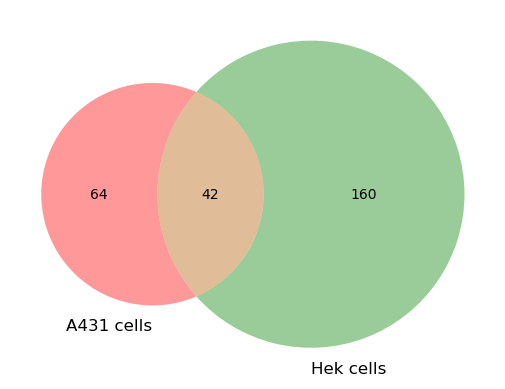

In [7]:
set_scincancer = set(pd.read_csv("data/sig_genes_A431.csv")["Feature"])
venn2([set_scincancer, sig_genes_new_analysis["Control"]], ("A431 cells", "Hek cells"))

plt.show()

In [8]:
intersect_adata = adata[:, adata.var.index.isin(list(set_scincancer.intersection(sig_genes_new_analysis["Control"])))]
intersect_adata.var

,Chr,Start,End,Strand,Length,Ensemble_ID,ensembl_gene_id,external_gene_name,description,gene_biotype,...,start_position,end_position,chromosome_name,total_values,highest_sample,NADcap_Control,NADcap_FK,NADcap_NRH,NADcap_Rot,sums
Feature,,,,,,,,,,,,,,,,,,,,,
ENSG00000260464.1,chr1,93847174,93848939,+,1766,ENSG00000260464,ENSG00000260464,NaN,novel transcript,lncRNA,...,93847174,93848939,1,3450,1802,True,True,True,True,4
ENSG00000283696.1,chr1;chr1,161399409;161421932,161399912;161422424,+;+,997,ENSG00000283696,ENSG00000283696,NaN,novel transcript,lncRNA,...,161399409,161422424,1,1099,439,True,True,False,True,3
ENSG00000143226.16,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,161505430;161505446;161505453;161505456;161505...,161505552;161505552;161506007;161505552;161505...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,5422,ENSG00000143226,ENSG00000143226,FCGR2A,Fc gamma receptor IIa [Source:HGNC Symbol;Acc:...,protein_coding,...,161505430,161524013,1,116,42,True,False,False,False,1
ENSG00000230530.2,chr3;chr3;chr3;chr3;chr3;chr3;chr3;chr3,45676369;45679043;45679232;45679513;45688376;4...,45680071;45680071;45680071;45680071;45688882;4...,-;-;-;-;-;-;-;-,4528,ENSG00000230530,ENSG00000230530,LIMD1-AS1,LIMD1 antisense RNA 1 [Source:HGNC Symbol;Acc:...,lncRNA,...,45676369,45689200,3,1482,709,True,True,True,True,4
ENSG00000177733.7,chr5,137745651,137754363,-,8713,ENSG00000177733,ENSG00000177733,HNRNPA0,heterogeneous nuclear ribonucleoprotein A0 [So...,protein_coding,...,137745651,137754363,5,176,41,True,True,False,True,3
ENSG00000248473.2,chr5;chr5;chr5;chr5;chr5;chr5;chr5,181178821;181187455;181188499;181188909;181190...,181180561;181188749;181188749;181189453;181191...,-;-;-;-;-;-;-,4759,ENSG00000248473,ENSG00000248473,LINC01962,long intergenic non-protein coding RNA 1962 [S...,lncRNA,...,181178821,181191852,5,5118,1350,True,True,True,True,4
ENSG00000196787.4,chr6,27133043,27133535,+,493,ENSG00000196787,ENSG00000196787,H2AC11,H2A clustered histone 11 [Source:HGNC Symbol;A...,protein_coding,...,27133043,27133535,6,133,41,True,True,True,False,3
ENSG00000075618.18,chr7;chr7;chr7;chr7;chr7;chr7;chr7;chr7;chr7;c...,5592816;5593848;5594547;5594686;5602872;560325...,5593768;5594027;5594896;5594820;5603413;560341...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,3699,ENSG00000075618,ENSG00000075618,FSCN1,fascin actin-bundling protein 1 [Source:HGNC S...,protein_coding,...,5592816,5606655,7,428,122,True,True,True,True,4
ENSG00000172115.9,chr7;chr7;chr7;chr7;chr7;chr7;chr7;chr7;chr7;c...,25118656;25123307;25123444;25123716;25123951;2...,25123849;25123849;25123849;25123849;25124127;2...,-;-;-;-;-;-;-;-;-;-;-;-;-;-,5791,ENSG00000172115,ENSG00000172115,CYCS,"cytochrome c, somatic [Source:HGNC Symbol;Acc:...",protein_coding,...,25118656,25125260,7,406,82,True,True,True,True,4
